In [458]:
import os
import sys
sys.path.append("../src")
import h5py
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from population_analysis.consts import TOTAL_TRIAL_MS, PRE_TRIAL_MS, POST_TRIAL_MS
from population_analysis.population.units import UnitPopulation
from population_analysis.consts import TOTAL_TRIAL_MS, SPIKE_BIN_MS

In [6]:
def _extract_timestamp_idxs(spike_timestamps, other_timestamps) -> list[[float, float, float]]:
    # return indices into spike_timestamps within a window of -200ms to +700ms for trials times in other_timestamps
    idx_ranges = []

    other_len = len(other_timestamps)
    other_one_tenth = int(1/10 * other_len)
    for idx, ts in enumerate(other_timestamps):
        if idx % other_one_tenth == 0:
            print(f" {round(100*(idx / other_len), 3)}%", end="")
        if np.isnan(ts):
            # idx_ranges.append(None)
            continue
        start_idx = np.where(ts - (PRE_TRIAL_MS/1000) < spike_timestamps)[0][0]  # First index in tuple, first index is the edge
        end_idx = np.where(ts + (POST_TRIAL_MS/1000) <= spike_timestamps)[0][0]
        ts_idx = np.where(ts >= spike_timestamps)[0][-1]  # Index of the event timestamp itself, next smallest value
        idx_ranges.append([start_idx, ts_idx, end_idx])
    print("")
    return idx_ranges


def _remove_by_idxs(lst: list, idxs: list[int]) -> list:
    # Filter out a list by indexes to not include
    l2 = []
    for idx, l in enumerate(lst):
        if idx in idxs:
            continue
        else:
            l2.append(l)
    return l2


def _demix_trials(saccade_idxs: list[list[float]], probe_idxs: list[list[float]]):
    # If a saccade and probe trial occur within +- .5 sec (500ms) then they should be considered a mixed trial
    trials = {
        "saccade": [],
        "probe": [],
        "mixed": []
    }

    # Find probes that occur within 500ms of a saccade, remove them from the list of possible
    # saccades/probes after finding them
    def within_window(list1, list2, label1, label2):  # Find events within eachothers bounds
        mixed = []
        l1_to_remove = []
        l2_to_remove = []

        for f_idx, first_idx in enumerate(list1):
            f_start = first_idx[0]  # first start
            f_end = first_idx[2]

            for s_idx, second_idx in enumerate(list2):
                s_event = second_idx[1]  # second event time idx
                if f_start <= s_event <= f_end:  # Found mixed
                    mixed.append({
                        label1: first_idx,
                        label2: second_idx
                    })
                    l2_to_remove.append(s_idx)
                    l1_to_remove.append(f_idx)
                    break
            list2 = _remove_by_idxs(list2, l2_to_remove)
            l2_to_remove = []
        list1 = _remove_by_idxs(list1, l1_to_remove)
        return [list1, list2, mixed]

    # Find saccades that occur within 500ms of a probe
    print("Demixing saccades within 500ms from a probe")
    saccade_idxs, probe_idxs, both = within_window(saccade_idxs, probe_idxs, "saccade", "probe")

    # Find probes that occur within 500ms of a saccade
    print("Demixing probes within 500ms of a saccade")
    probe_idxs, saccade_idxs, both2 = within_window(probe_idxs, saccade_idxs, "probe", "saccade")

    trials["saccade"] = saccade_idxs
    trials["probe"] = probe_idxs
    trials["mixed"] = [*both, *both2]

    return trials



In [7]:
filename = 'E:\\PopulationAnalysis\\2023-05-16\\mlati7\\output.hdf'

In [8]:
data = h5py.File(filename)
spike_clusters = np.array(data["spikes"]["clusters"])
spike_timestamps = np.array(data["spikes"]["timestamps"])
probe_timestamps = np.array(data["stimuli"]["dg"]["probe"]["timestamps"])
saccade_timestamps = np.array(data["saccades"]["predicted"]["left"]["nasal"]["timestamps"])

In [9]:
unit_pop = UnitPopulation(spike_timestamps, spike_clusters)

print("Extracting saccade spike timestamps..")
saccade_spike_range_idxs = _extract_timestamp_idxs(spike_timestamps, saccade_timestamps)
print("Extracting probe spike timestamps..")
probe_spike_range_idxs = _extract_timestamp_idxs(spike_timestamps, probe_timestamps)



Extracting saccade spike timestamps..
 0.0% 9.962% 19.924% 29.886% 39.848% 49.81% 59.772% 69.734% 79.696% 89.658% 99.62%
Extracting probe spike timestamps..
 0.0% 9.995% 19.991% 29.986% 39.981% 49.977% 59.972% 69.967% 79.963% 89.958% 99.953%
Demixing saccades within 500ms from a probe
Demixing probes within 500ms of a saccade


In [410]:
trials = _demix_trials(saccade_spike_range_idxs, probe_spike_range_idxs)

unit_pop.add_probe_trials(trials["probe"])
unit_pop.add_saccade_trials(trials["saccade"])
unit_pop.add_mixed_trials(trials["mixed"])

Demixing saccades within 500ms from a probe
Demixing probes within 500ms of a saccade


In [425]:
# Calculate the firing rate of each unit for all trials
self = unit_pop

# for trial in self._trials:
trial = self._trials[1]

trial_spike_times = self.spike_timestamps[trial.start:trial.end]
trial_start = self.spike_timestamps[trial.start]
trial_end = self.spike_timestamps[trial.end]
trial_spike_clusters = self.spike_clusters[trial.start:trial.end]


In [426]:
bins = np.arange(trial_start, self.spike_timestamps[trial.end], SPIKE_BIN_MS/1000)
digs = np.digitize(trial_spike_times, bins)
firingrate = np.unique(digs, return_counts=True)[1] / SPIKE_BIN_MS

unique_units = np.unique(trial_spike_clusters)

In [413]:
unique_units

array([  5,   8,  11,  18,  32,  39,  44,  55,  57,  61,  63,  75,  78,
        82,  96, 116, 121, 127, 136, 138, 151, 155, 163, 164, 165, 166,
       176, 182, 210, 230, 237, 238, 240, 248, 251, 260, 264, 267, 281,
       286, 288, 293, 297, 305, 311, 313, 324, 326, 333, 341, 345, 352,
       355, 359, 365, 367, 368, 369, 371, 372, 373, 396, 399, 408, 410,
       413, 414, 416, 417, 418, 421, 422, 424, 429, 431, 432, 433, 434,
       438, 450, 451, 452, 453, 455, 456, 457, 464, 465, 467, 469, 474,
       482, 494, 500, 508, 510, 516, 530, 531, 534, 541, 545, 547, 549,
       555, 564, 565, 569, 580, 586], dtype=uint32)

In [414]:

trial_len = trial_spike_times[0] - trial_spike_times[-1]

In [415]:
trial_len / .2

-3.4849999999983083

In [416]:
len(unique_units),len(trial_spike_clusters)

(110, 397)

In [450]:
all_units_mask = np.broadcast_to(trial_spike_clusters[:,None].T, (len(unique_units), len(trial_spike_clusters)))

In [451]:
all_units_mask = all_units_mask == unique_units[:,None]  # Mask on trial for each unique value

In [452]:
unmasked_spike_times = np.broadcast_to(trial_spike_times, (len(unique_units), *trial_spike_times.shape))

In [453]:
unit_spike_times = ma.array(unmasked_spike_times, mask=~all_units_mask)

In [454]:
unit_spike_times[2].compressed()

array([3471.861, 3471.876, 3471.891, 3471.899, 3471.91 , 3471.915,
       3471.932, 3471.953, 3471.971, 3471.979, 3471.989, 3472.004,
       3472.036, 3472.05 , 3472.058, 3472.083, 3472.09 , 3472.098,
       3472.113, 3472.121, 3472.152, 3472.173, 3472.18 , 3472.195,
       3472.218, 3472.23 , 3472.237, 3472.246, 3472.255, 3472.266,
       3472.273, 3472.28 , 3472.288, 3472.297, 3472.304, 3472.31 ,
       3472.328, 3472.34 , 3472.353, 3472.38 , 3472.395, 3472.402,
       3472.44 , 3472.447, 3472.462, 3472.473, 3472.482, 3472.495,
       3472.523, 3472.537, 3472.545])

In [455]:
l = np.histogram(unit_spike_times[2].compressed(), bins=bins, density=False)

In [459]:
l[0]/SPIKE_BIN_MS

array([0.1 , 0.05, 0.15, 0.05, 0.05, 0.05, 0.1 , 0.05, 0.05, 0.05, 0.05,
       0.1 , 0.1 , 0.05, 0.05, 0.05, 0.1 , 0.  , 0.15, 0.1 , 0.1 , 0.15,
       0.1 , 0.05, 0.1 , 0.  , 0.1 , 0.05, 0.  , 0.1 , 0.1 , 0.1 , 0.  ,
       0.1 ])

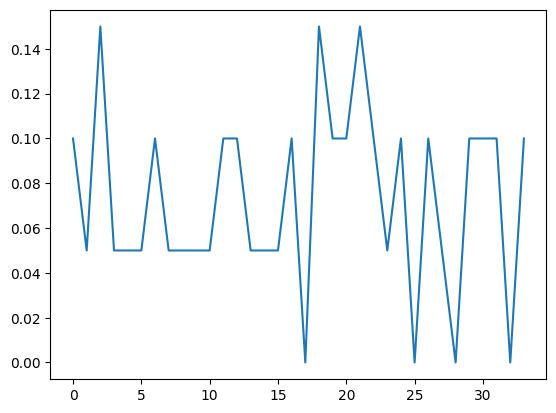

In [457]:
plt.plot(l[0]/SPIKE_BIN_MS)